# Example `alphatools` workflow with proteomics data

## An example dataset: Alzheimer study

This notebook demonstrates core `alphatools` functionality for proteomics data loading, preprocessing and visualization. 

AlphaTools is designed to perform two main functions: First, provide a unified interface between search engine outputs and downstream processing. Second, provide downstream proteomics workflows entirely compatible with transcriptomics and the AnnData framework. Below we step through an `alphatools` example by using a published dataset by Bader et al. [2], who measured cerebrospinal fluid proteomes in order to discover biomarkers for Alzheimer's disease.

[2]: Bader, Jakob M., et al. "Proteome profiling in cerebrospinal fluid reveals novel biomarkers of Alzheimer's disease." Molecular systems biology 16.6 (2020): e9356.

In [ ]:
%load_ext autoreload
%autoreload 2

import tempfile

import numpy as np
import pandas as pd
from alphabase.tools.data_downloader import DataShareDownloader

# Data handling
from alphatools.io.anndata_factory import AnnDataFactory
from alphatools.pp.data import add_metadata, filter_by_metadata, filter_data_completeness
from alphatools.pp.transform import nanlog
from alphatools.pp.impute import impute_gaussian
from alphatools.tl.embeddings import pca
from alphatools.pp.batch_correction import scanpy_pycombat, drop_singleton_batches

from alphatools.pl.plots import Plots, add_lines, label_plot
from alphatools.pl.figure import create_figure, label_axes, save_figure
from alphatools.pl.colors import BaseColors, BasePalettes, BaseColormaps

### Preparing the dataset using `alphatools` loaders and AnnData factory. 

In the case of this study, the full output of the DIANN search is saved as a report file of precursors, from which precursor or protein-level data can be extracted. `alphatools` handles this filtering with its AnnData factory class, drawing on the reader functionalities of `alphabase`. The resulting AnnData object contains protein-group quantities and any number of feature-metadata columns (for example, protein groups may have genes as secondary annotation, precursors may have protein groups and genes as secondary annotation).

In [ ]:
# Download the dataset
url = "https://datashare.biochem.mpg.de/s/zNtxEQJTdqQYLd4"
with tempfile.TemporaryDirectory() as temp_dir:
    file_path = DataShareDownloader(url=url, output_dir=temp_dir).download()
    factory = AnnDataFactory.from_files(file_paths=file_path, reader_type="diann")

# Create the AnnData object, where the row index corresponds to samples and the column names correspond to proteins
adata = factory.create_anndata()

# Use the builtin dataframe conversion to get a quick overview of the data
display(adata.to_df().iloc[:5, :5])

/var/folders/kh/g2qb3dp91m9bx0yxm0t02f380000gn/T/tmp_ap42icy/report.parquet does not yet exist
/var/folders/kh/g2qb3dp91m9bx0yxm0t02f380000gn/T/tmp_ap42icy/report.parquet successfully downloaded (91.135817527771 MB)


proteins,1433B-2_HUMAN;1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433T_HUMAN
raw_name,,,,,
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA01,5898647.0,7653369.5,198099.203125,5859688.5,240594.546875
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA02,6674590.5,6645735.0,237327.343750,5854608.0,288184.968750
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA03,5213923.5,3370416.0,145326.515625,4977316.0,184137.562500
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA04,4843322.5,5707478.5,149581.875000,5262512.0,124084.984375
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA05,7309056.0,7943046.0,230455.875000,7263083.0,315826.812500


### Upstream data operation: log2 transformation

when running `alphatools.pp`'s `nanlog()` We get a warning that our data contains NaN values, which are ignored in the log-transform.
When verbosity is set to 1, `nanlog()` alerts to special values for which log-transformation is not possible.

In [ ]:
nanlog(adata, base=2, verbosity=1)

### Integrating study metadata

The AnnData format provides a solution to a key problem encountered in every data-analysis project: How to keep a matrix of numerical values permanently and safely aligned with column and row annotations. This is notably difficult with dataframes, as multilevel column indices are cumbersome and non-numeric columns in one dataframe cause problems with downstram analyses methods that expect numerical features. The `add_metadata` function from the preprocessing module ensures alignment of observations and variables from the start.

☝️ Importantly, while the original AnnData implementation only enforces shape compatibility, `alphatools.pp.data.add_metadata()` enforces matching indices. This means that even if the initial data and the incoming metadata were to be in different orders, quantitative and metadata information for a given sample are always matched. 

In [ ]:
# Download the metadata
url = "https://datashare.biochem.mpg.de/s/iSgdPnHgczbcktF"
with tempfile.TemporaryDirectory() as temp_dir:
    file_path = DataShareDownloader(url=url, output_dir=temp_dir).download()
    metadata = pd.read_excel(file_path).dropna(subset=["sample name"])

/var/folders/kh/g2qb3dp91m9bx0yxm0t02f380000gn/T/tmpjx3xbg0h/annotation%20of%20samples_AM1.5.11.xlsx does not yet exist
/var/folders/kh/g2qb3dp91m9bx0yxm0t02f380000gn/T/tmpjx3xbg0h/annotation%20of%20samples_AM1.5.11.xlsx successfully downloaded (0.028104782104492188 MB)


In [ ]:
# Basic cleaning of the metadata prior to merging
metadata["sample name"] = metadata["sample name"].str.replace(".raw.PG.Quantity", "", regex=False)
metadata = metadata.set_index("sample name", drop=False)

In [ ]:
# The metadata contains information for more samples than are in our data
print(f"AnnData shape: {adata.shape}")
print(f"Metadata shape: {metadata.shape}")

AnnData shape: (61, 2162)
Metadata shape: (210, 14)


Since metadata and proteomics data have shared indices, matching is instant and safe:

In [ ]:
# Match the metadata to the AnnData object
print(f"Anndata shape prior to matching: {adata.shape}")
adata = add_metadata(
    adata=adata,  # The AnnData object we want to add metadata to. Its obs index should match the index of the metadata
    incoming_metadata=metadata,  # The metadata dataframe we want to add. Its index should match the index of adata.obs
    axis=0,  # This means that we add metadata to the rows (0) and not columns (1)
    keep_data_shape=False,  # This means that we will drop any samples for which there is no corresponding row in the metadata
)
print(f"Anndata shape after matching: {adata.shape}")
print()

Anndata shape prior to matching: (61, 2162)
Anndata shape after matching: (61, 2162)



We can inspect that the metadata was correctly added:

In [ ]:
# From now on, the metadata is stored in adata.obs
print("The sample-level metadata:")
display(adata.obs.head())

# For now, the feature (i.e. protein) metadata is a dataframe with only one column. We could easily add more protein annotations like GO-terms to it
print("The feature-level metadata:")
display(adata.var.head())

# And the protein abundances are stored in adata.X, which is a numpy array and perfectly suited for numerical operations
print("The protein abundances:")
display(adata.X[:5, :5])

The sample-level metadata:


,sample name,collection site,age,gender,t-tau [ng/L],p-tau [ng/L],Abeta-42 [ng/L],Abeta-40 [ng/L],Abeta ratio,biochemical AD classification,clinical AD diagnosis,MMSE score,cohort sample ID,comment
raw_name,,,,,,,,,,,,,,
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA01,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,71.0,f,703.0,85.0,562.0,NaN,NaN,biochemical control,NaN,NaN,ID_708,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA02,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,77.0,m,518.0,91.0,334.0,NaN,NaN,biochemical AD,NaN,NaN,ID_722,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA03,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,75.0,m,974.0,87.0,515.0,NaN,NaN,biochemical AD,NaN,NaN,ID_734,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA04,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,72.0,f,950.0,109.0,394.0,NaN,NaN,biochemical AD,NaN,NaN,ID_742,NaN
20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleA05,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,Sweden,63.0,f,873.0,88.0,234.0,NaN,NaN,biochemical AD,NaN,NaN,ID_757,NaN


The feature-level metadata:


""
proteins
1433B-2_HUMAN;1433B_HUMAN
1433E_HUMAN
1433F_HUMAN
1433G_HUMAN
1433T_HUMAN


The protein abundances:


array([[22.491953, 22.867664, 17.595863, 22.482393, 17.876244],
       [22.670248, 22.663998, 17.85652 , 22.481142, 18.136635],
       [22.313938, 21.684496, 17.14894 , 22.246937, 17.490425],
       [22.207565, 22.444422, 17.190577, 22.32732 , 16.920969],
       [22.801254, 22.92126 , 17.81413 , 22.79215 , 18.268774]],
      dtype=float32)

### Use `alphatools` to generate an overview of the metadata

In order to understand the properties of our data, we may want to generate overviews of certain columns in the metadata. To quickly generate publication-grade visuals, we utilize `alphatools.pl.plots.Plots` and its asssociated functionalities. 

An example of `create_figure`'s iterative subplotting feature starts with specifying a number of numerical features we want to visualize:

In [ ]:
# Check distribution of age and other numerical columns
numerical_columns = ["age", "t-tau [ng/L]", "p-tau [ng/L]", "Abeta-42 [ng/L]"]

☝️ A particular painpoint for many analyses is that the same *levels* should ideally have the same color throughout the entire analysis (i.e. it can be confusing if "disease" is colored red in one plot and green in the next). This can be annoyingly subtle to get right, which is why `alphatools` plots support a *color_dict* we can create upfront. This way, the same level is colored uniformly across all our plots.

In [ ]:
# Assign a distinct color to each of our columns
palette = BasePalettes.get("qualitative", n=len(numerical_columns))

# Save the combination of numerical column and color in a dictionary
color_dict = dict(zip(numerical_columns, palette, strict=False))

Next, we instantiate a multi-panel figure with one facet for each of our numerical columns. A figure like this could be used for a supplementary figure, where the distribution of relevant columns should be shown.

INFO:root:Column 'age' found in: data.obs.columns. Using that
INFO:root:Column 't-tau [ng/L]' found in: data.obs.columns. Using that
INFO:root:Column 'p-tau [ng/L]' found in: data.obs.columns. Using that
INFO:root:Column 'Abeta-42 [ng/L]' found in: data.obs.columns. Using that


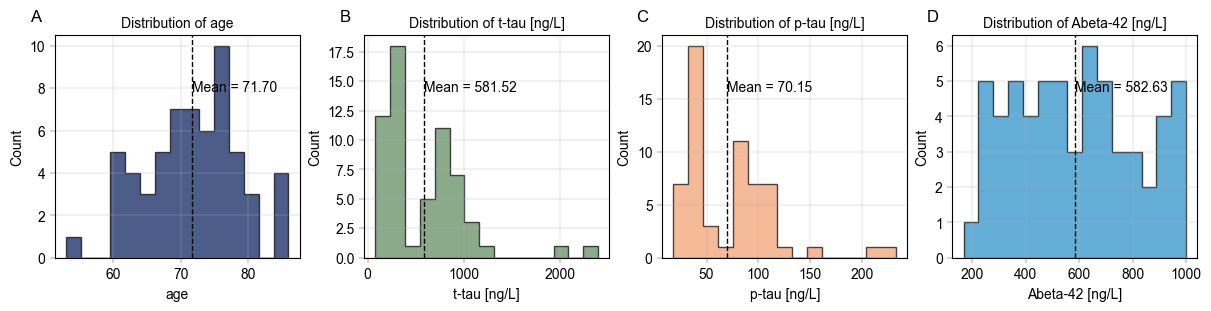

In [ ]:
fig, axm = create_figure(1, len(numerical_columns), figsize=(3 * len(numerical_columns), 3))

# Iterate over the columns and generate the histograms.
# Note that we also iterate over a string of letters to label the individual subplots with A, B, C, ...
for col, enumeration in zip(numerical_columns, "ABCDEFGHIJKLMNOP", strict=False):
    ax = axm.next()  # Go to the next facette of the AxesManager

    # Plot the histogram for the current column
    Plots.histogram(
        ax=ax,
        bins=15,
        data=adata,
        value_column=col,
        color=color_dict[col],
        # Add whatever flourish we want for the histograms
        hist_kwargs={
            "histtype": "stepfilled",
            "alpha": 0.7,
            "edgecolor": "black",
        },
    )

    # Label the individual axes (note that this takes the Axes object as an argument, so
    # everything gets layered onto the same figure)
    label_axes(
        ax=ax,
        xlabel=col,
        ylabel="Count",
        title=f"Distribution of {col}",
        enumeration=enumeration,
    )

    # Indicate means with a vertical line
    mean = adata.obs[col].mean()  # calculate the mean of the current column in the metadata
    add_lines(
        ax=ax,
        intercepts=mean,
        linetype="vline",
        color="black",
    )

    # Add a label for each mean
    label_plot(
        ax=ax,
        x_values=[mean],
        y_values=[0.75],
        labels=[f"Mean = {mean:.2f}"],
        # The code is necessary to position all mean labels at the same height.
        # It essentially means "Use data coordinates for the x-axis, but use axes coordinates (0-1) for the y-axis".
        label_kwargs={"transform": ax.get_xaxis_transform()},
    )

    # Since the figure size is fixed from the initial generation of the subplot, we can save it looking exactly as we see below in the notebook
    save_figure(
        fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
        filename="continuous_var_overview.svg",
        output_dir="./example_outputs",
    )

    # TODO: Implement barplots for categorical variables.

### Next, 
we would like a small panel to highlight the distribution of our protein intensities with highlights the 10 most abundant proteins, and look at the protein distribution across all our samples to check if we need imputation.

In [ ]:
# Some custom code to find the 5 most abundant proteins
protein_abundances = np.nanmedian(adata.X, axis=0)
top_5_protein_indices = np.argsort(protein_abundances)[-5:]
top_5_protein_names = adata.var_names[top_5_protein_indices]
top_5_protein_medians = protein_abundances[top_5_protein_indices]

# Sort the top 5 proteins by their median abundance
median_order = np.argsort(top_5_protein_medians)
top_5_protein_medians = top_5_protein_medians[median_order]
top_5_protein_names = top_5_protein_names[median_order]

# Mark the top proteins in the anndata object
adata.var["status"] = "other"
adata.var.loc[top_5_protein_names, "status"] = "top 5"

# Specify how to color the ranked proteins
rank_color_dict = {"top 5": BaseColors.get("red"), "other": BaseColors.get("lightblue")}

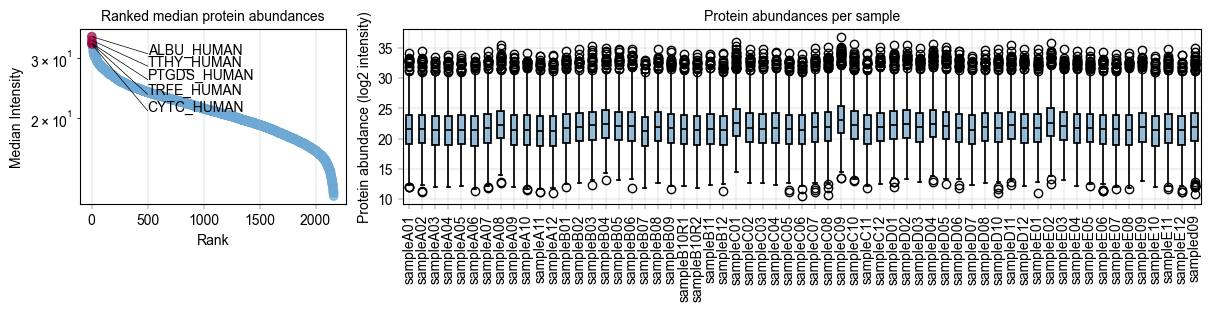

In [ ]:
# Generate a panel to contain the rank plot and the protein abundance boxplots
fig, axm = create_figure(1, 2, figsize=(12, 3), gridspec_kwargs={"width_ratios": [1, 3]})

# First, show the protein values
ax = axm.next()
Plots.rank_median_plot(
    data=adata,
    ax=ax,
    color_map_column="status",  # The column to indicate which proteins are special
    color_dict=rank_color_dict,  # How to color the special proteins
    scatter_kwargs={
        "alpha": 0.7,
    },
)

label_axes(
    ax=ax,
    title="Ranked median protein abundances",
)

label_plot(
    ax=ax,
    x_values=range(len(top_5_protein_names)),
    y_values=top_5_protein_medians[median_order],
    labels=top_5_protein_names[median_order],
    x_anchors=[500],
    y_padding_factor=4.5,
)


# Next, show the protein intensity per sample
ax = axm.next()

Plots.boxplot(
    ax=ax,
    data=adata.T,
    direct_columns=adata.obs.index.tolist(),
)

# This is a critical strength of not having a custom end-to-end plotting function:
# The ax object is always accessible, so a little matplotlib code can get rid of
# cumbersome long xtick labels:
xtick_labels = [item.get_text() for item in ax.get_xticklabels()]  # Get xtick labels directly from axes
xtick_labels = [x.split("_")[-1] for x in xtick_labels]  # Shorten the xtick labels to make them more readable
_ = ax.set_xticklabels(xtick_labels, rotation=90)  # Set the new xtick labels

label_axes(
    ax=ax,
    title="Protein abundances per sample",
    ylabel="Protein abundance (log2 intensity)",
)

# Save the figure
save_figure(
    fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
    filename="protein_abundance_overview.svg",
    output_dir="./example_outputs",
)

### Filter study data based on metadata

In order to analyse subcohorts of the study, it can be useful to filter by a metadata variable like age or gender. `alphatools` offers an intuitive way to do so via `alphatools.pp.data.filter_by_metadata()`, which takes a dictionary of filter conditions returns a subsetted AnnData object. 



In [ ]:
# Example: Subset to samples where 'gender' is "f":
adata_f = filter_by_metadata(
    adata=adata,
    filter_dict={"gender": "f"},
    axis=0,  # samples
    action="keep",
)
print(adata_f.obs["gender"].value_counts())

# Example: Subset to samples where 'gender' is "f" and 'age' is over 70:
adata_f_over70 = filter_by_metadata(
    adata=adata,
    filter_dict={
        "gender": "f",
        "age": (70, None),  # None means no upper bound
    },
    axis=0,  # samples
    logic="and",  # Both conditions have to be met
    action="keep",
)
print(adata_f_over70.obs["gender"].value_counts())
print(adata_f_over70.obs["age"].describe())

# Example:

gender
f    24
Name: count, dtype: int64
gender
f    16
Name: count, dtype: int64
count    16.000000
mean     73.312500
std       3.198307
min      70.000000
25%      71.000000
50%      72.000000
75%      74.250000
max      80.000000
Name: age, dtype: float64


### Filter proteins based on their completeness across samples

A frequent action is to get the "core proteome" of a dataset, i.e. the proteins that have no missing values in any sample. We can perform this via our `filter_data_completeness` function by setting the `max_missing` argument to 0.

In [ ]:
print(f"Number of proteins in the study: {adata.X.shape[1]}")

adata_core = filter_data_completeness(
    adata=adata,
    max_missing=0,
    action="drop",
)

print(f"Number of proteins with complete data: {adata_core.X.shape[1]}")

if adata_core.to_df().isna().sum().sum() != 0:
    raise ValueError("There are still missing values in the data after filtering for complete proteins.")
else:
    print("No missing values remain after filtering for complete proteins.")

INFO:root:pp.filter_data_completeness(): drop 1026 / 2162 features with >0.00 missing in any group.


Number of proteins in the study: 2162
Number of proteins with complete data: 1136
No missing values remain after filtering for complete proteins.


### Examine the PCA clustering of data, colored by different variables

PCA values are computed and saved to the same AnnData instance, making use of its `obsm`, `varm`, and `uns` (unstructured) data fields.

In [ ]:
# We restrict our dataset to proteins with no more than 25 % missing values across all samples
adata_25pc = adata.copy()
filter_data_completeness(
    adata=adata_25pc,
    max_missing=0.25,
    action="drop",
)

# We impute the remaining missing values from a downshifted gaussian distribution
impute_gaussian(
    adata=adata_25pc,
)

# Add PCA embeddings to the AnnData object by utilizing its 'obsm' attribute
pca(adata_25pc, n_comps=10)

# Locating the PCA results
print("\nPCA Components: adata.obsm['X_pca'] with shape (n_obs x n_comps):")
print(adata_25pc.obsm["X_pca_obs"].shape)

print("\nPCA loadings: adata.varm['PCs'] with shape (n_var x n_comps):")
print(adata_25pc.varm["PCs_obs"].shape)

print("\nRatio of explained variance: uns['pca']['variance_ratio'] with shape (n_comps,):")
print(adata_25pc.uns["variance_pca_obs"]["variance_ratio"])

print("\nExplained variance: uns['pca']['variance'] with shape (n_comps):")
print(adata_25pc.uns["variance_pca_obs"]["variance"])

INFO:root:pp.filter_data_completeness(): drop 533 / 2162 features with >0.25 missing in any group.
INFO:root: impute_gaussian: Imputation complete. Imputed 22855 NaN values with Gaussian distribution.
INFO:alphatools.tl.embeddings:computing PCA



PCA Components: adata.obsm['X_pca'] with shape (n_obs x n_comps):
(61, 10)

PCA loadings: adata.varm['PCs'] with shape (n_var x n_comps):
(2162, 10)

Ratio of explained variance: uns['pca']['variance_ratio'] with shape (n_comps,):
[0.1683405  0.08758316 0.04475449 0.03914252 0.03708593 0.03377207
 0.02909582 0.02593896 0.02431665 0.02348845]

Explained variance: uns['pca']['variance'] with shape (n_comps):
[251.25902  130.7235    66.79896   58.42272   55.353127  50.406982
  43.427387  38.71557   36.294155  35.058025]


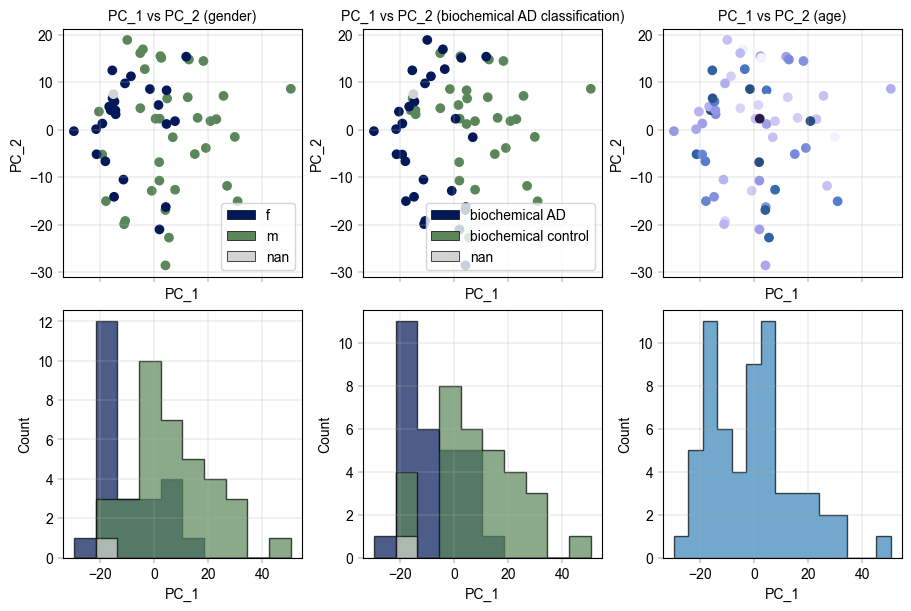

In [ ]:
# Visualizing the PCA results
fig, axm = create_figure(2, 3, figsize=(9, 6), subplots_kwargs={"sharex": True})

# We can get the PCA component values into a dataframe
pca_df = pd.DataFrame(
    adata_25pc.obsm["X_pca_obs"],
    index=adata_25pc.obs.index,
    columns=[f"PC_{i + 1}" for i in range(adata_25pc.obsm["X_pca_obs"].shape[1])],
)
pca_df = pca_df.join(adata_25pc.obs)

# Color by gender
ax = axm.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="gender",
    legend="auto",
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (gender)",
)

# TODO: Scatter should have an additional x_labels and y_labels argument, making it possible to pass ranking information to x_values and a_values but display categorical levels of interest.

# Color by biochemical AD classification
ax = axm.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="biochemical AD classification",
    legend="auto",
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (biochemical AD classification)",
)

# Color by age
# TODO: Legend with small colorbar when a colormap is used
ax = axm.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="age",
    palette=BaseColormaps.get("sequential"),
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (age)",
)

# TODO: add_labels should work on anndata directly

# Go on and add histograms for first component
ax = axm.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_1",
    color_map_column="gender",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="Count",
)

ax = axm.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_1",
    color_map_column="biochemical AD classification",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="Count",
)

ax = axm.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    bins=15,
    value_column="PC_1",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="Count",
)

### Or a more creative approach to one of the variables, e.g. Alzheimer's classification:


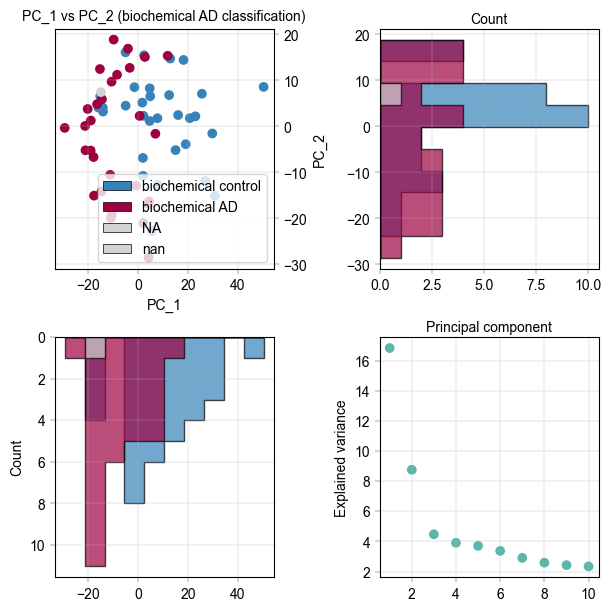

In [ ]:
# Visualizing the PCA results
fig, axm = create_figure(2, 2, figsize=(6, 6))

# We can get the PCA component values into a dataframe
pca_df = pd.DataFrame(
    adata_25pc.obsm["X_pca_obs"],
    index=adata_25pc.obs.index,
    columns=[f"PC_{i + 1}" for i in range(adata_25pc.obsm["X_pca_obs"].shape[1])],
)
pca_df = pca_df.join(adata_25pc.obs)

# Ensure that the colors are the same across all plots
color_dict = {
    "biochemical control": BaseColors.get("blue"),
    "biochemical AD": BaseColors.get("red"),
    "NA": BaseColors.get("grey"),
}

# Color by biochemical AD classification
ax = axm.next()
Plots.scatter(
    ax=ax,
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="biochemical AD classification",
    legend="auto",
    color_dict=color_dict,
)
label_axes(
    ax=ax,
    xlabel="PC_1",
    ylabel="PC_2",
    title="PC_1 vs PC_2 (biochemical AD classification)",
)
# Move the y-axis label to the right side of the plot
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# Go on and add 90 degree tilted histograms for the second component
ax = axm.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_2",
    color_map_column="biochemical AD classification",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
        "orientation": "horizontal",
    },
    color_dict=color_dict,
)
label_axes(
    ax=ax,
    xlabel="Count",
)
ax.xaxis.set_label_position("top")

# Add a histogram for the first component
ax = axm.next()
Plots.histogram(
    ax=ax,
    data=pca_df,
    value_column="PC_1",
    color_map_column="biochemical AD classification",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
    color_dict=color_dict,
)
label_axes(
    ax=ax,
    ylabel="Count",
)
ax.invert_yaxis()

# And lastly a scree plot to show the explained varince
ax = axm.next()
Plots.scree_plot(
    ax=ax,
    adata=adata_25pc,
    n_pcs=10,
    color=BaseColors.get("green"),
)
label_axes(
    ax=ax,
    xlabel="Principal component",
    ylabel="Explained variance",
)
ax.xaxis.set_label_position("top")

It appears there is separation of the Alzheimer's and control samples on the first principal component. We can examine the loadings of the first component to get an idea of which proteins are regulated.

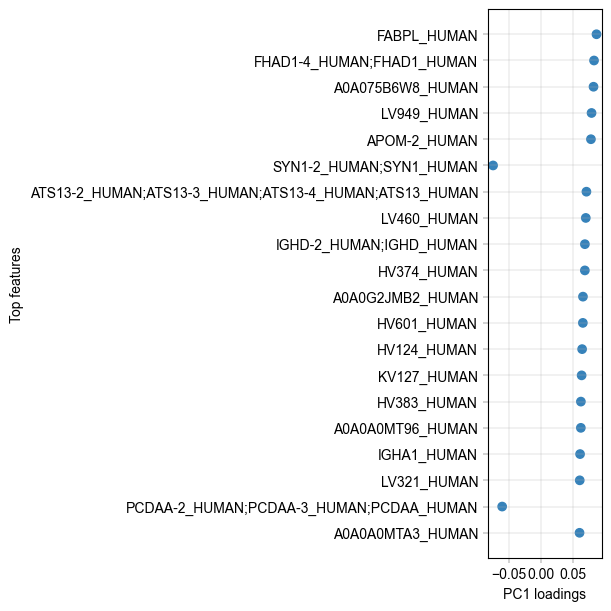

In [ ]:
fig, axm = create_figure(1, 1, figsize=(6, 6))
# TODO: All plots should have an optional ax argument, e.g. if no ax is given, they should call create_figure(1,1) internally
Plots.plot_pca_loadings(
    data=adata_25pc,
    ax=axm.next(),
    dim=1,
)

The two highest loadings on PC1 are LV949 and A0A075B6W8. We can take these along and check their differential abundance between treatments. 

## Batch correction

A simple and effective way of correcting for batch effects was published under the name ComBat [REF]. Based on Empirical Bayes methods, it can remove technical or sampling batch effects while retaining biological information. 

The function implementation has two major failure modes which causes batch correction to fail: A) If a batch occurs exactly once or B) if there are NaN-values in the data. We can check for both and mitigate them:

In [ ]:
impute_gaussian(adata_25pc)
adata_25pc = drop_singleton_batches(adata_25pc, batch="gender")

INFO:root: impute_gaussian: No NaN values found, no imputation performed.
INFO:alphatools.pp.batch_correction: coerce_nans_to_batch: Replacing NaNs in gender with 'NA'...
INFO:alphatools.pp.batch_correction: coerce_nans_to_batch: Some levels of batch 'gender' have only one sample. Dropped samples and their respective value in 'gender': [('20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1_sampleB10R1', 'NA')]


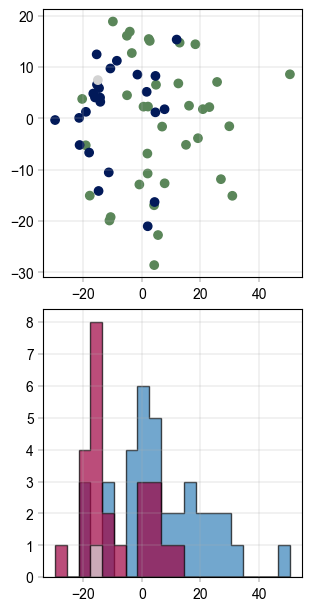

In [ ]:
# visualize the data before batch correction
fig, axm = create_figure(2, 1, figsize=(3, 6))
Plots.scatter(
    ax=axm.next(),
    data=pca_df,
    x_column="PC_1",
    y_column="PC_2",
    color_map_column="gender",
)
Plots.histogram(
    ax=axm.next(),
    data=pca_df,
    value_column="PC_1",
    bins=20,
    color_map_column="gender",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
    color_dict={
        "m": BaseColors.get("blue"),
        "f": BaseColors.get("red"),
    },
)

In [ ]:
# Apply PyCombat batch correction
adata_25pc_corr = adata_25pc.copy()
scanpy_pycombat(
    adata=adata_25pc_corr,
    batch="gender",
)

INFO:alphatools.pp.batch_correction: scanpy_pycombat: pply pyComBat to correct for gender
... storing 'collection site' as categorical
... storing 'gender' as categorical
... storing 'biochemical AD classification' as categorical
... storing 'status' as categorical


Found 7 genes with zero variance.


/Users/shanibm/Desktop/alphatools/venv_312/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:348: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/shanibm/Desktop/alphatools/venv_312/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:348: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/shanibm/Desktop/alphatools/venv_312/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:348: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/shanibm/Desktop/alphatools/venv_312/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:348: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


INFO:alphatools.tl.embeddings:computing PCA
INFO:root:Column 'gender' found in: data.obs.columns. Using that
INFO:root:Column 'gender' found in: data.obs.columns. Using that
/Users/shanibm/Desktop/alphatools/src/alphatools/pl/colors.py:226: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if na_values:


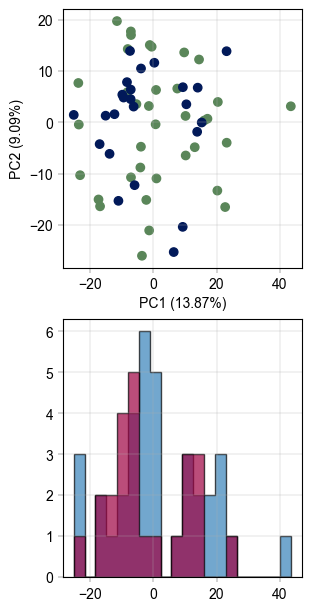

In [ ]:
# recompute pca TODO: Remove dataframe based plotting for pca_plot or adapter down the line
pca(adata_25pc_corr, n_comps=10)
pca_df_corr = pd.DataFrame(
    adata_25pc_corr.obsm["X_pca_obs"],
    index=adata_25pc_corr.obs.index,
    columns=[f"PC_{i + 1}" for i in range(adata_25pc_corr.obsm["X_pca_obs"].shape[1])],
)
pca_df_corr = pca_df_corr.join(adata_25pc_corr.obs)

# Visualize again
fig, axm = create_figure(2, 1, figsize=(3, 6))
Plots.plot_pca(
    ax=axm.next(),
    data=adata_25pc_corr,
    x_column=1,
    y_column=2,
    color_map_column="gender",
)
Plots.histogram(
    ax=axm.next(),
    data=pca_df_corr,
    value_column="PC_1",
    bins=20,
    color_map_column="gender",
    hist_kwargs={
        "histtype": "stepfilled",
        "alpha": 0.7,
        "edgecolor": "black",
    },
    color_dict={
        "m": BaseColors.get("blue"),
        "f": BaseColors.get("red"),
    },
)